In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.random as random

import numpyro 
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, NUTS, MCMC, Predictive
from numpyro.infer.autoguide import AutoDelta

from cognax.decisions import TRDM

numpyro.enable_x64(True)
numpyro.set_platform('cpu')

In [2]:
# --- plotting ---
def dhist(dat, nvals, ax, alpha=.3):
    p,b = np.histogram(dat, bins='auto', density=True)
    w = b[1]-b[0]
    p *= float(len(dat))/nvals
    return ax.bar(b[1:]-w, p, width=w, alpha=.3)

def choice_rt_hist(choice_rts, n_choice, ax):
    choices, rts = choice_rts[..., 0], choice_rts[..., 1] 

    for choice_i in range(n_choice):
        choice_i_rts = rts[choices == choice_i]
        dhist(choice_i_rts, choices.size, ax)
        

def plot_trdm(choice_rts, fitted_trdm, max_RT=3.0, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 3))    
    
    xvals = np.linspace(0.0, max_RT, 1000)
    choice_rt_hist(choice_rts, fitted_trdm.n_choice, ax)

    for choice_i in range(fitted_trdm.n_choice):
        vals = np.vstack([np.ones(len(xvals)) * choice_i, xvals]).T     
        likes = np.exp(fitted_trdm.log_prob(vals))
        ax.plot(xvals, likes, lw=2.)

    ax.set_xlim(0, max_RT)

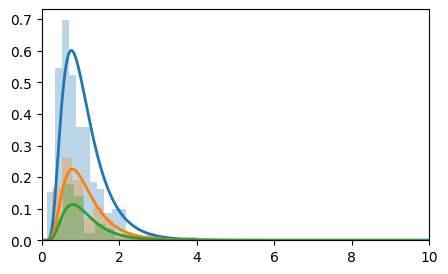

In [4]:
# synthesize choice_RT data
data_key, map_key, mcmc_key = random.split(random.PRNGKey(0), 3)

v = jnp.array([.7, .35, .15])
alpha = jnp.array([1, 1, 1])
sigma = jnp.array([.5, .5, .5])
t0 = 0
trdm = TRDM(v, alpha, sigma, t0, rel_max_time=10.0)
choice_RTs = trdm.sample(data_key, (500,))

plot_trdm(choice_RTs, trdm, max_RT=10)

In [5]:
max_nondecision_time = jnp.min(choice_RTs[..., 1])

def model(data):    
    a = jnp.ones(3)
    
    with numpyro.plate('n_choice', 3):
        v = numpyro.sample('v', dist.LogNormal(0, 1))
        sigma = numpyro.sample('sigma', dist.Beta(1, 1))
    
    t0 = numpyro.sample('t0', dist.Uniform(0, max_nondecision_time))

    with numpyro.plate('n_trial', 500, dim=-1):
        numpyro.sample('obs', TRDM(v, a, sigma, t0), obs=data)

100%|██████████| 1000/1000 [00:01<00:00, 924.85it/s, init loss: 1624.7655, avg. loss [951-1000]: 764.7015]


Text(0.5, 1.0, 'best fit params vs. real data')

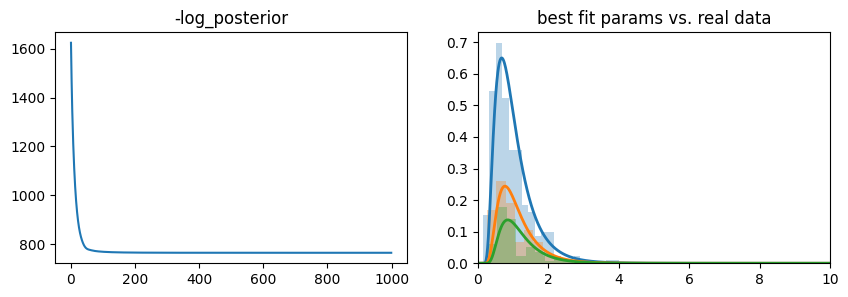

In [6]:
guide = AutoDelta(model)
optimizer = numpyro.optim.Adam(0.03)
svi = SVI(model, guide, optimizer, Trace_ELBO())
    
svi_result = svi.run(map_key, 1000, choice_RTs)

params = guide.sample_posterior(random.PRNGKey(0), svi_result.params, choice_RTs)

fig, axs = plt.subplots(ncols=2, figsize=(10, 3))

axs[0].plot(svi_result.losses)
axs[0].set_title('-log_posterior')
plot_trdm(choice_RTs, TRDM(params['v'], jnp.ones(3), params['sigma'], params['t0']), max_RT=10., ax=axs[1])
axs[1].set_title('best fit params vs. real data')

Text(0.5, 1.0, 'actual')

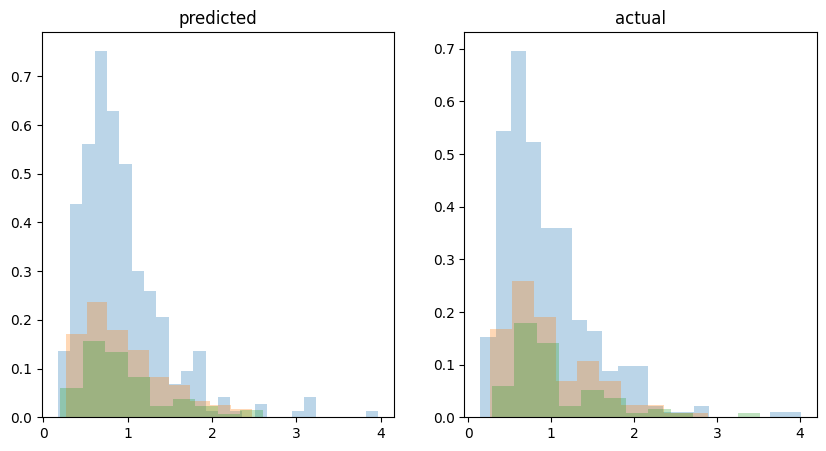

In [7]:
predictive = Predictive(model, guide=guide, params=params, num_samples=1) # gives us 1 sample for each original sample in the data
map_predictive = predictive(random.PRNGKey(0), None)['obs']

fig, axs = plt.subplots(ncols=2, figsize=(10,5))

choice_rt_hist(map_predictive, n_choice=3, ax=axs[0])
axs[0].set_title('predicted')

choice_rt_hist(choice_RTs, n_choice=3, ax=axs[1])
axs[1].set_title('actual')

sample: 100%|██████████| 1000/1000 [00:05<00:00, 175.19it/s, 15 steps of size 2.98e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma[0]      0.64      0.05      0.63      0.55      0.70    263.12      1.00
  sigma[1]      0.56      0.04      0.56      0.50      0.62    250.55      1.01
  sigma[2]      0.50      0.04      0.50      0.45      0.56    237.05      1.02
        t0      0.10      0.03      0.10      0.05      0.15    238.52      1.01
      v[0]      0.74      0.04      0.74      0.68      0.80    338.90      1.00
      v[1]      0.37      0.05      0.37      0.30      0.45    370.97      1.00
      v[2]      0.26      0.05      0.26      0.18      0.33    292.31      1.01

Number of divergences: 0


Text(0.5, 1.0, 'best fit params vs. real data')

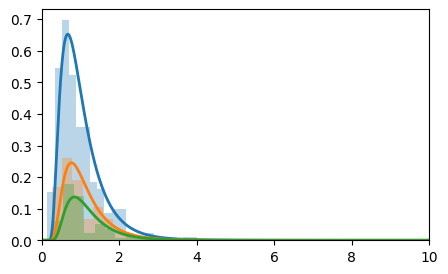

In [8]:
# --- fit full posteriors with MCMC ---
kernel = NUTS(model)
sampler = MCMC(kernel,
               num_warmup=500,
               num_samples=500,
               num_chains=1)

sampler.run(mcmc_key, choice_RTs)

sampler.print_summary()

mean_params = {key: np.mean(val, axis=0) for key, val in sampler.get_samples().items()}

trdm = TRDM(mean_params['v'], jnp.ones(3), mean_params['sigma'], mean_params['t0'])
plot_trdm(choice_RTs, trdm, max_RT=10.)
axs[1].set_title('best fit params vs. real data')

Text(0.5, 1.0, 'actual')

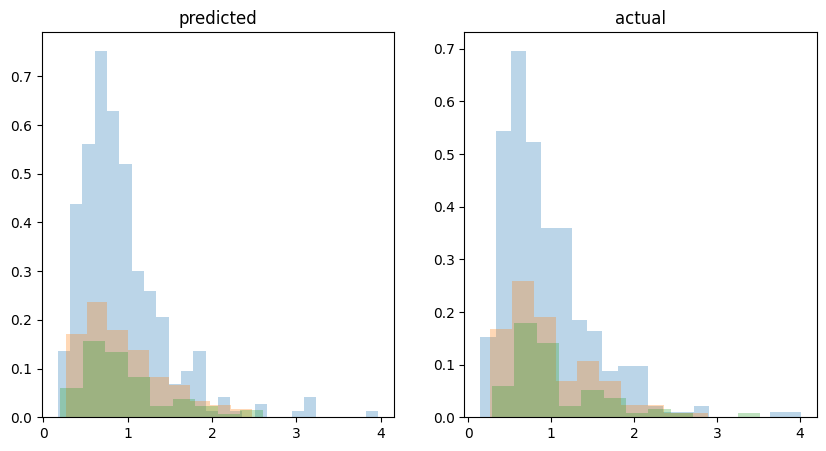

In [9]:
predictive = Predictive(model, posterior_samples=sampler.get_samples())

predictive_samps = predictive(random.PRNGKey(0), None)['obs']

fig, axs = plt.subplots(ncols=2, figsize=(10,5))

choice_rt_hist(map_predictive, n_choice=3, ax=axs[0])
axs[0].set_title('predicted')

choice_rt_hist(choice_RTs, n_choice=3, ax=axs[1])
axs[1].set_title('actual')